# Collect data DONE
# Cleanup data
# WordCloud
# Sentiment (Vader) -> check rougness of lyrics per year/ check number of abcense words
# topic modelling
# Web wiki db -> plot map of relation between birth place and artists in top rank
# Train NN T5 ->< try to explain lyrics -> explain all text

# Setup

In [27]:
!pip install torch --quiet
!pip install sklearn --quiet
!pip install datasets --quiet
!apt install git-lfs --quiet
!pip install transformers --quiet
!pip install sentencepiece --quiet

The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.



In [92]:
!pip install scikit-learn --quiet

In [98]:
!pip install nltk --quiet

In [ ]:
!pip install -U pip setuptools wheel --quiet
!pip install -U spacy==2.3.9 --quiet

In [41]:
!pip install pandas --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install wordcloud --quiet

In [13]:
!pip install beautifulsoup4 --quiet
!pip install lyricsgenius --quiet
!pip install billboard.py --quiet

In [14]:
# !pip install git+https://github.com/johnwmillr/LyricsGenius.git --quiet

In [15]:
!pip install python-dotenv
from dotenv import load_dotenv
import dotenv
import os
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [6]:
# Import Genious access token

In [7]:
load_dotenv(os.path.join(os.getcwd(),'.env'))
GENIOUS_ACCESS_TOKEN = os.environ.get('GENIOUS_ACCESS_TOKEN')

In [110]:
import pandas as pd
import numpy as np
import requests

# import seaborn as sns
from IPython.display import HTML, display
from bs4 import BeautifulSoup

import lyricsgenius as genius
import billboard
import sys
import re

import nltk
from nltk.translate.bleu_score import sentence_bleu
if not nltk.data.find('corpora/stopwords'):
    # Download the 'stopwords' dataset
    nltk.download('stopwords')
from nltk.corpus import stopwords


from datetime import datetime, date, timedelta
from wordcloud import WordCloud,ImageColorGenerator
import matplotlib.pyplot as plt

# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
# from collections import Counter
# from os import path
# from PIL import Image
# from keras.models import model_from_json
# import pickle


import torch
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from transformers import T5ForConditionalGeneration, T5Tokenizer
import random
from tqdm.auto import tqdm, trange
from huggingface_hub import notebook_login
import os
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None
display(HTML("<style>.container { width:100% !important; }</style>"))
% config InlineBackend.figure_format = 'png'

UsageError: Line magic function `%` not found.


In [100]:
def disable_pandas_warnings():
    import warnings
    warnings.resetwarnings()  # Maybe somebody else is messing with the warnings system?
    warnings.filterwarnings('ignore')  # Ignore everything
    # ignore everything does not work: ignore specific messages, using regex
    warnings.filterwarnings('ignore', '.*A value is trying to be set on a copy of a slice from a DataFrame.*')
    warnings.filterwarnings('ignore', '.*indexing past lexsort depth may impact performance*')

In [101]:
disable_pandas_warnings()

# Data Collecting

In [23]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days // 7)):
        yield start_date + timedelta(n*7)

In [24]:
def collect_songs_from_billboard_each_day(start_date_str, end_date_str, chart_name='hot-100', table_path = None,to_csv = False):
    start_date = datetime.strptime(
        start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

    columns = ["Rank",
                    "Song Title",
                    "Artist",
                    "Date",
                    "Year"]
    dataset = pd.DataFrame(columns = columns, data = [])
    if to_csv:
        dataset.to_csv(table_path,index=False)

    sys.stdout.write(
        "\r" + "Collecting Songs from " + start_date_str + " to " + end_date_str + " via https://www.billboard.com")
    sys.stdout.flush()
    for single_date in tqdm(daterange(start_date, end_date)):
        print(single_date.strftime('%Y-%m-%d'))
        chart = billboard.ChartData(chart_name, date=single_date.strftime('%Y-%m-%d'))
        for song in chart:
            row = {
                "Rank": song.rank,
                "Song Title": song.title,
                "Artist": song.artist,
                "Date": single_date.strftime('%Y-%m-%d'),
                "Year": single_date.strftime('%Y')
            }
            if to_csv:
                pd.DataFrame([row]).to_csv(table_path, mode='a',index=False, header=False)
            else:
                dataset = dataset.append(row, ignore_index=True)  #pd.concat([dataset,pd.DataFrame(row)],ignore_index=True)#
    if not to_csv:
        return dataset


In [ ]:
all_songs = collect_songs_from_billboard_each_day('2003-02-17', '2023-02-17',table_path='all_songs_20.csv',to_csv = True)

In [4]:
all_songs = pd.read_csv("all_songs_20.csv")

In [5]:
all_songs.head(70)

,Rank,Song Title,Artist,Date,Year
0,1,All I Have,Jennifer Lopez Featuring LL Cool J,2003-02-17,2003
1,2,In Da Club,50 Cent,2003-02-17,2003
2,3,Mesmerize,Ja Rule Featuring Ashanti,2003-02-17,2003
3,4,"Bump, Bump, Bump",B2K & P. Diddy,2003-02-17,2003
4,5,Cry Me A River,Justin Timberlake,2003-02-17,2003
...,...,...,...,...,...
65,66,No Letting Go,Wayne Wonder,2003-02-17,2003
66,67,Make It Clap,Busta Rhymes Featuring Spliff Star,2003-02-17,2003
67,68,Can't Stop,Red Hot Chili Peppers,2003-02-17,2003
68,69,What Happened To That Boy,Baby Featuring Clipse,2003-02-17,2003


In [6]:
all_songs["Artist"][all_songs['Artist'] == "Jackson 5"] = "The Jackson 5"
all_songs["Artist"][all_songs['Artist'] == "Beatles"] = "The Beatles"

In [8]:
all_songs.drop_duplicates(subset=['Artist','Song Title']).to_csv('unique_songs_20.csv', mode='a',index=False)

In [9]:
api = genius.Genius(GENIOUS_ACCESS_TOKEN,timeout = 5, sleep_time=0.015, verbose=False)

In [10]:
all_songs = pd.read_csv("unique_songs_20.csv")

GENIOUS_CSV = 'all_songs_data_new.csv'
columns = [ "Year",
        "Rank",
        "Song Title",
        "Artist",
        "Primary Artists",
        "Lyrics",
        "Song URL",
        "Song id",
        "Song stats",
        "Song annotations"]
dataset = pd.DataFrame(columns = columns, data = [])
dataset.to_csv(GENIOUS_CSV,index=False)


all_song_data = pd.DataFrame()
start_time = datetime.now()
print("Started at {}".format(start_time))
for i in range(0, len(all_songs)):
    rolling_pct = int((i / len(all_songs)) * 100)
    # print(str(rolling_pct) + "% complete." + " Collecting Record " + str(i) + " of " +
    #       str(len(all_songs)) + ". Year " + str(all_songs.iloc[i]['Year']) + "." + " Currently collecting " +
    #       all_songs.iloc[i]['Song Title'] + " by " + all_songs.iloc[i]['Artist'] + " " * 50, end="\r")
    song_title = all_songs.iloc[i]['Song Title']
    song_title = re.sub(" and ", " & ", song_title)
    artist_name = all_songs.iloc[i]['Artist']
    artist_name = re.sub(" and ", " & ", artist_name)

    try:
        song = api.search_song(song_title, artist=artist_name)
        primary_artists = song.primary_artist
        song_lyrics = re.sub("\n", " ", song.lyrics)  #Remove newline breaks, we won't need them.
        song_url = song.url
        song_id = song.id
        song_stats = song.stats
        song_annotations = api.song_annotations(song.id)
    except:
        primary_artists = "null"
        song_lyrics = "null"
        song_url = "null"
        song_id = "null"
        song_stats = 'null'
        song_annotations = 'null'

    row = {
        "Year": all_songs.iloc[i]['Year'],
        "Rank": all_songs.iloc[i]['Rank'],
        "Song Title": all_songs.iloc[i]['Song Title'],
        "Artist": all_songs.iloc[i]['Artist'],
        "Primary Artists": primary_artists,
        "Lyrics": song_lyrics,
        "Song URL": song_url,
        "Song id": song_id,
        "Song stats": song_stats,
        "Song annotations": song_annotations
    }
    pd.DataFrame([row]).to_csv(GENIOUS_CSV, mode='a',index=False, header=False)
    # all_song_data = all_song_data.append(row, ignore_index=True)
end_time = datetime.now()
print("\nCompleted at {}".format(start_time))
print("Total time to collect: {}".format(end_time - start_time))


Started at 2023-03-18 15:38:32.176995

Completed at 2023-03-18 15:38:32.176995
Total time to collect: 5:20:57.880854


In [16]:
all_song_data.tail(5)

,Year,Rank,Song Title,Artist,Primary Artists,Lyrics,Song URL,Song id,Song stats
6,2022,7,Kill Bill,SZA,"SZA, 0 songs",TranslationsEspañolPortuguêsItalianoTürkçeDeut...,https://genius.com/Sza-kill-bill-lyrics,8616820,"Stats('unreviewed_annotations, concurrents, ho..."
7,2022,8,Feliz Navidad,Jose Feliciano,"José Feliciano, 0 songs","Feliz Navidad Lyrics[Letra de ""Feliz Navidad""]...",https://genius.com/Jose-feliciano-feliz-navida...,623111,"Stats('unreviewed_annotations, hot, pageviews')"
8,2022,9,Anti-Hero,Taylor Swift,"Taylor Swift, 0 songs",TranslationsPortuguêsEspañolTürkçeFrançais中文Ne...,https://genius.com/Taylor-swift-anti-hero-lyrics,8434253,"Stats('unreviewed_annotations, concurrents, ho..."
9,2022,10,Unholy,Sam Smith & Kim Petras,"Sam Smith & Kim Petras, 0 songs",TranslationsFrançaisEspañolNederlandsDeutschال...,https://genius.com/Sam-smith-and-kim-petras-un...,8302862,"Stats('unreviewed_annotations, concurrents, ho..."
10,2022,11,The Christmas Song (Merry Christmas To You),Nat King Cole,"The Nat “King” Cole Trio, 0 songs",The Christmas Song (Merry Christmas to You) (O...,https://genius.com/The-nat-king-cole-trio-the-...,1717793,"Stats('unreviewed_annotations, hot, pageviews')"


In [19]:
loaded_song_dataset = pd.read_csv("all_songs_data_new.csv")

In [20]:
display(loaded_song_dataset.head())
display(loaded_song_dataset.tail())

,Year,Rank,Song Title,Artist,Primary Artists,Lyrics,Song URL,Song id,Song stats,Song annotations
0,2003,1,All I Have,Jennifer Lopez Featuring LL Cool J,"Jennifer Lopez, 0 songs","All I Have Lyrics[Intro: Jennifer Lopez, Sampl...",https://genius.com/Jennifer-lopez-all-i-have-l...,32015.0,"Stats('unreviewed_annotations, hot, pageviews')","[('Oh-oh-oh\n Uh, baby, don’t go\n All my, all..."
1,2003,2,In Da Club,50 Cent,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,3,Mesmerize,Ja Rule Featuring Ashanti,"Ja Rule, 0 songs","Mesmerize Lyrics[Intro: Ja Rule] Haha, yeah Wh...",https://genius.com/Ja-rule-mesmerize-lyrics,23989.0,"Stats('unreviewed_annotations, hot, pageviews')","[('Haha, yeah\n Whattup ma? How you been?\n Ye..."
3,2003,4,"Bump, Bump, Bump",B2K & P. Diddy,"B2K, 0 songs","Bump, Bump, Bump Lyrics[Intro: P. Diddy & B2K]...",https://genius.com/B2k-bump-bump-bump-lyrics,32117.0,"Stats('unreviewed_annotations, hot, pageviews')","[('(Come on, it’s ”Pandemonium”, baby)', [['Th..."
4,2003,5,Cry Me A River,Justin Timberlake,NaN,NaN,NaN,NaN,NaN,NaN


,Year,Rank,Song Title,Artist,Primary Artists,Lyrics,Song URL,Song id,Song stats,Song annotations
9035,2023,80,The Black Seminole.,Lil Yachty,"Lil Yachty, 0 songs",TranslationsEspañol​the BLACK seminole. Lyrics...,https://genius.com/Lil-yachty-the-black-semino...,8763573.0,"Stats('unreviewed_annotations, hot, pageviews')","[('African Rambo with more ammo', [['John Jame..."
9036,2023,86,Fin de Semana,Junior H X Oscar Maydon,NaN,NaN,NaN,NaN,NaN,NaN
9037,2023,96,Hey Mor,Ozuna Featuring Feid,"Ozuna, 0 songs","Hey Mor Lyrics[Letra de ""Hey Mor"" ft. Feid] [...",https://genius.com/Ozuna-hey-mor-lyrics,8400438.0,"Stats('unreviewed_annotations, hot, pageviews')",[]
9038,2023,99,Never Gonna Not Dance Again,P!nk,"P!nk, 0 songs",TranslationsItalianoNever Gonna Not Dance Agai...,https://genius.com/P-nk-never-gonna-not-dance-...,8475909.0,"Stats('unreviewed_annotations, hot, pageviews')","[('For once I wouldn’t start a fight', [['This..."
9039,2023,100,Dancin' In The Country,Tyler Hubbard,"Tyler Hubbard, 0 songs",Dancin’ In The Country Lyrics[Verse 1] Them ne...,https://genius.com/Tyler-hubbard-dancin-in-the...,8255170.0,"Stats('unreviewed_annotations, hot')",[]


In [21]:
songs_with_lyrics_dataset = loaded_song_dataset.dropna(subset=['Lyrics'])
songs_with_lyrics_dataset.to_csv('all_songs_no_null.csv',index=False)

## Data cleaning

* Clean lyrics and save to csv

In [22]:
# Define a regex pattern to match text before the word "Lyrics"
pattern = re.compile(r".*Lyrics", re.DOTALL)

# Define a function to clean the "Lyrics" column
def clean_lyrics(lyrics):
    # Remove all text before the word "Lyrics"
    cleaned_lyrics = re.sub(pattern, "Lyrics", lyrics)
    # Remove any text inside square brackets
    cleaned_lyrics = re.sub(r"\[.*?\]", "", cleaned_lyrics)
    # remove all occurances of word Lyrics
    cleaned_lyrics = re.sub(r"\bLyrics\b", "", cleaned_lyrics)
    cleaned_lyrics = re.sub(r"\bEmbed\b", "", cleaned_lyrics)
    # Return the cleaned lyrics
    return cleaned_lyrics

In [23]:
loaded_song_dataset = pd.read_csv("all_songs_no_null.csv")

# Apply the clean_lyrics function to the "Lyrics" column of the DataFrame
loaded_song_dataset["Lyrics"] = loaded_song_dataset["Lyrics"].apply(clean_lyrics)

# Save the cleaned DataFrame to a new CSV file
loaded_song_dataset.to_csv('cleaned_songs.csv', index=False)

# Data Statistic

## Word Cloud

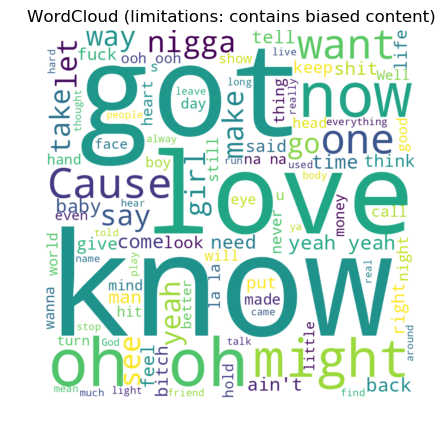

In [26]:
# Create and generate a word cloud image:
df = pd.read_csv("cleaned_songs.csv")
lyrics_text = ' '.join(df['Lyrics'])

wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(str(lyrics_text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud (limitations: contains biased content)")
plt.show()

## Profanity filter and Wordcloud

In [102]:
bad_word_file = 'Facebook Bad Words List 2022.txt'
with open(bad_word_file) as f:
    bad_words = f.read().split(",")

In [103]:
len(bad_words)

1110

In [117]:
def clean_profanity_lyrics(lyrics):
    # Remove all non-alphanumeric characters and convert to lowercase
    clean_text = re.sub(r'[^a-zA-Z\s]', '', lyrics)
    cleaned_lyrics = re.sub(r'[^\w\s]', '', clean_text).lower()
    # Tokenize the lyrics into a list of words
    words = cleaned_lyrics.split()
    # Remove stop words
    words = [word for word in words if word not in bad_words]
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

In [118]:
def clean_non_profanity(lyrics):
    # Remove all non-alphanumeric characters and convert to lowercase
    clean_text = re.sub(r'[^a-zA-Z\s]', '', lyrics)
    cleaned_lyrics = re.sub(r'[^\w\s]', '', clean_text).lower()
    # Tokenize the lyrics into a list of words
    words = cleaned_lyrics.split()
    # Remove stop words
    words = [word for word in words if word in bad_words]
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)


In [119]:
def tokenize_lyrics(lyrics):
    # Remove all non-alphanumeric characters and convert to lowercase
    clean_text = re.sub(r'[^a-zA-Z\s]', '', lyrics)
    cleaned_lyrics = re.sub(r'[^\w\s]', '', clean_text).lower()
    # Tokenize the lyrics into a list of words
    words = cleaned_lyrics.split()
    return words

In [120]:
df = pd.read_csv("cleaned_songs.csv")

df['Tokenized Lyrics'] = df['Lyrics'].apply(tokenize_lyrics)
df['Cleaned Lyrics'] = df['Lyrics'].apply(clean_profanity_lyrics)
df['Bad Words'] = df['Lyrics'].apply(clean_non_profanity)

df.to_csv('cleaned_songs.csv', index=False)

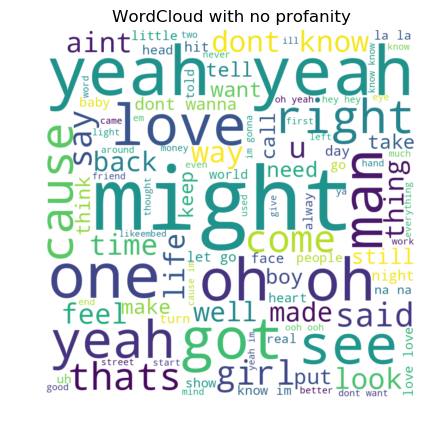

In [121]:
df = pd.read_csv("cleaned_songs.csv")
lyrics_text = ' '.join(df['Cleaned Lyrics'])

wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(str(lyrics_text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud with no profanity")
plt.show()

## Data Statistic per year

In [ ]:
data =  pd.read_csv('cleaned_songs.csv')
# Create a new DataFrame with the year, number of songs, number of unique words, and average number of words per song for each year
year_stats = pd.DataFrame(columns=['Year', 'Num Songs', 'Num Unique Words', 'Avg Words Per Song'])
for year in data['Year'].unique():
    year_data = data[data['Year'] == year]
    num_songs = len(year_data)
    all_words = []
    unique_words = set()
    for lyrics in year_data['Tokenized Lyrics']:
        all_words += lyrics
        unique_words.update(lyrics)
    num_unique_words = len(unique_words)
    avg_words_per_song = len(all_words) / num_songs
    year_stats = year_stats.append({'Year': year, 'Num Songs': num_songs, 'Num Unique Words': num_unique_words, 'Avg Words Per Song': avg_words_per_song}, ignore_index=True)

# Save the year_stats DataFrame to a CSV file
year_stats.to_csv('year_stats.csv', index=False)

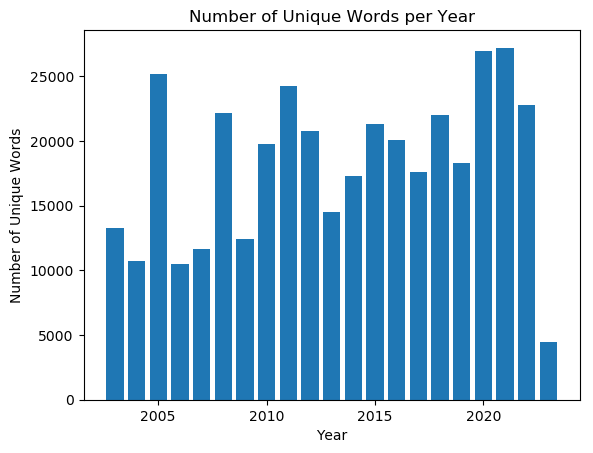

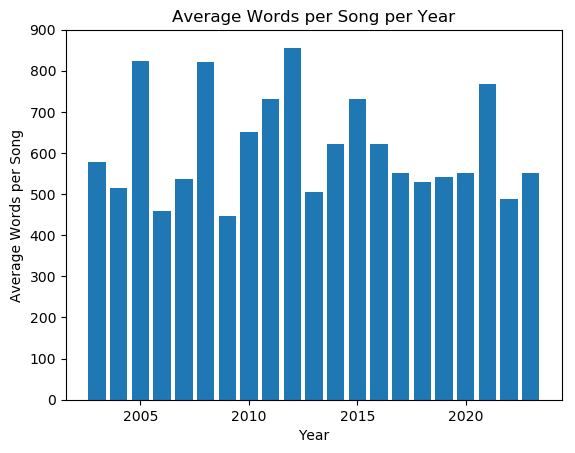

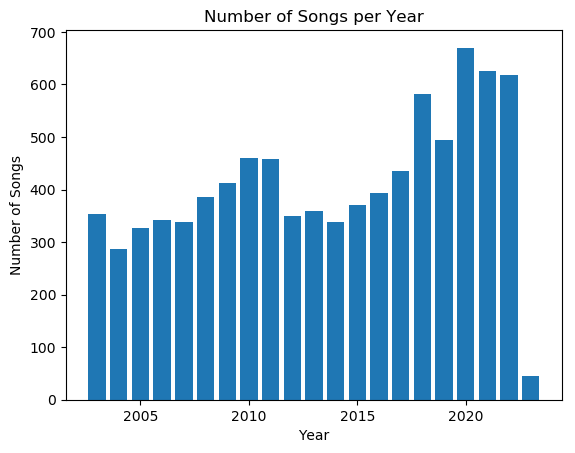

In [66]:
# Plot the year_stats DataFrame as a bar chart
plt.bar(year_stats['Year'], year_stats['Num Unique Words'])
plt.title('Number of Unique Words per Year')
plt.xlabel('Year')
plt.ylabel('Number of Unique Words')
plt.show()

plt.bar(year_stats['Year'], year_stats['Avg Words Per Song'])
plt.title('Average Words per Song per Year')
plt.xlabel('Year')
plt.ylabel('Average Words per Song')
plt.show()

plt.bar(year_stats['Year'], year_stats['Num Songs'])
plt.title('Number of Songs per Year')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.show()

## Understanding lyrics with T5 transformer

* TODO: ADD BLEU/ROUGE evaluation

In [ ]:
MODEL_NAME = 'igorktech/t5-base-en'
SAVE_MODEL_NAME = 't5-base-en-explainer'
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 4
REPORT_STEPS = 1000
EPOCHS = 1
LEARNING_RATE = 1e-4
TASK_PREFIX = "explain | "
MAX_INPUT = 64
MAX_OUTPUT = 64
# model.config.max_length = MAX_OUTPUT #not mandatory
SAVE_TO_HUB = True

In [ ]:
pairs = []
for a, b in zip(data['train']['short'], data['train']['long']):
    pairs.append([TASK_PREFIX + a, b])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:

# Split data into train and validation sets
train_pairs, val_pairs = train_test_split(pairs, test_size=0.1)

# Define training and validation functions
def train(model, optimizer, tokenizer, train_pairs):
    model.train()
    losses = []
    for i in trange(0, int(len(train_pairs) / TRAIN_BATCH_SIZE)):
        batch = train_pairs[i * TRAIN_BATCH_SIZE: (i + 1) * TRAIN_BATCH_SIZE]
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding="longest", \
                      max_length=MAX_INPUT, truncation=True).to(model.device)
        y = tokenizer([p[1] for p in batch], return_tensors='pt', padding="longest", \
                      max_length=MAX_OUTPUT, truncation=True, ).to(model.device)
        y.input_ids[y.input_ids == 0] = -100
        loss = model(
            input_ids=x.input_ids,
            attention_mask=x.attention_mask,
            labels=y.input_ids,
            decoder_attention_mask=y.attention_mask,
            return_dict=True
        ).loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        if i % REPORT_STEPS == 0:
            print('train step', i, 'loss', np.mean(losses[-REPORT_STEPS:]))

def evaluate(model, tokenizer, val_pairs):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i in trange(0, int(len(val_pairs) / EVAL_BATCH_SIZE)):
            batch = val_pairs[i * EVAL_BATCH_SIZE: (i + 1) * EVAL_BATCH_SIZE]
            x = tokenizer([p[0] for p in batch], return_tensors='pt', padding="longest", \
                          max_length=MAX_INPUT, truncation=True).to(model.device)
            y = tokenizer([p[1] for p in batch], return_tensors='pt', padding="longest", \
                          max_length=MAX_OUTPUT, truncation=True, ).to(model.device)
            y.input_ids[y.input_ids == 0] = -100
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            total_loss += loss.item()
        avg_loss = total_loss / int(len(val_pairs) / EVAL_BATCH_SIZE)
        print('validation loss', avg_loss)
        return avg_loss

# Train the model for multiple epochs
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    print('EPOCH', epoch)
    random.shuffle(train_pairs)
    train(model, optimizer, tokenizer, train_pairs)
    val_loss = evaluate(model, tokenizer, val_pairs)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model.pt')


### Save model

In [ ]:
if SAVE_TO_HUB:
    notebook_login()
    model.push_to_hub(SAVE_MODEL_NAME)
    tokenizer.push_to_hub(SAVE_MODEL_NAME)
else:
    model.save_pretrained(SAVE_MODEL_NAME)
    tokenizer.save_pretrained(SAVE_MODEL_NAME)

### Testing model

In [ ]:
model.eval()


def answer(x, **kwargs):
    inputs = tokenizer(x, return_tensors='pt').to(model.device)
    with torch.no_grad():
        hypotheses = model.generate(**inputs, **kwargs)
    return tokenizer.decode(hypotheses[0], skip_special_tokens=True)

In [ ]:
print('model: ', answer(TASK_PREFIX + 'What is love?'))

In [ ]:
reference = ['the', 'cat', 'is', 'on', 'the', 'mat']
candidate = ['the', 'cat', 'is', 'sitting', 'on', 'the', 'mat']

# Set weights for 3-gram
weights = (0.33, 0.33, 0.33)

# Compute BLEU score with 3-gram
score = sentence_bleu([reference], candidate, weights=weights)

print(score)